# Lab Instructions

You are part of a data team for a financial institution that uses an AI model to determine who will and will not be granted a loan.  Recently, there have been complaints from customers that the model unfairly discriminates based on the applicant's age and sex. A court has ordered that the financial institution must provide information about how the model works.  

Data from recent loan applications is given in `loan_data.csv`.  The data dictionary is below:

| Feature              | Description | Data Type |
| :---------------- | :------: | ----: |
|person_age|Age of the person|Float
|person_gender|Gender of the person|Categorical
|person_education|Highest education level|Categorical
|person_income|Annual income|Float
|person_emp_exp|Years of employment experience|Integer
|person_home_ownership|Home ownership status (e.g., rent, own, mortgage)|Categorical
|loan_amnt|Loan amount requested|Float
|loan_intent|Purpose of the loan|Categorical
|loan_int_rate|Loan interest rate|Float
|loan_percent_income|Loan amount as a percentage of annual income|Float
|cb_person_cred_hist_length|Length of credit history in years|Float
|credit_score|Credit score of the person|Integer
|previous_loan_defaults_on_file|Indicator of previous loan defaults|Categorical
|loan_status (target variable)|Loan approval status: 1 = approved; 0 = rejected|Integer

Visualize the relationship between age, sex and 5 other features with `loan_status`.  Which features seem to drive the model's decision to grant a loan?  Which seem unrelated?  Should the financial institution be concerned about potential legal trouble?  Make sure to justify your answers with specific references to your visualizations.



In [1]:
# Load data and quick inspection
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# use set_theme instead of deprecated set
sns.set_theme(style='whitegrid')

df = pd.read_csv('loan_data.csv')

# show first rows and quick summary
print('shape:', df.shape)
df.head()


shape: (45000, 14)


,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,71,male,Associate,46817.176426,3,RENT,11567.737650,MEDICAL,10.351469,0.247083,5,806.869094,No,0
1,34,male,High School,79093.494008,17,OWN,9519.674498,MEDICAL,11.168902,0.120360,1,604.330171,No,0
2,80,male,Associate,67819.614431,20,OWN,16226.604002,PERSONAL,12.293112,0.239261,11,685.933579,No,0
3,40,female,Associate,49599.861220,0,RENT,15641.221708,VENTURE,10.327926,0.315348,14,629.190150,No,0
4,43,male,Doctorate,99833.900180,8,OWN,12727.942517,EDUCATION,9.338069,0.127491,16,638.298168,No,1



Missing values by column:
person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64

loan_status distribution:
loan_status
0    0.891267
1    0.108733
Name: proportion, dtype: float64


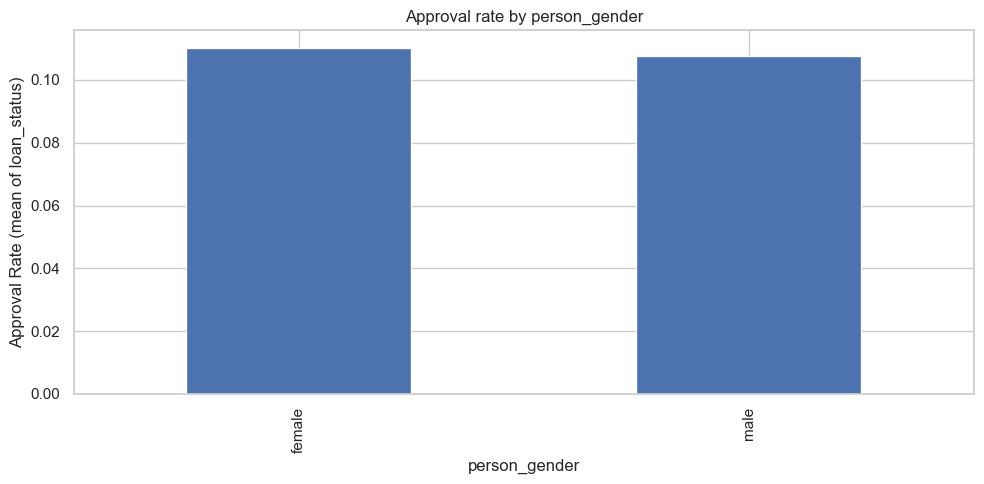

C:\Users\marke\AppData\Local\Temp\ipykernel_8824\1906202224.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rates = df.groupby([cat, hue])['loan_status'].mean().unstack(hue) if hue else df.groupby(cat)['loan_status'].mean()


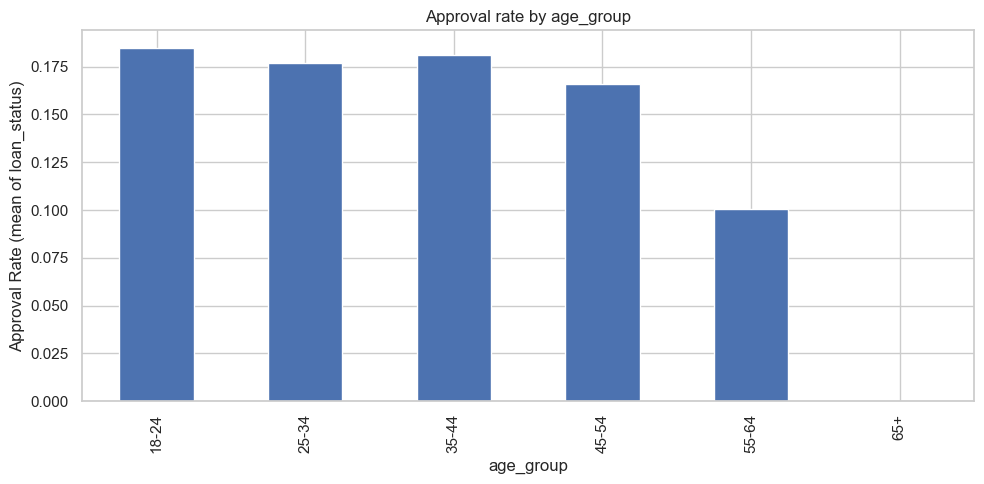

<Figure size 1000x500 with 0 Axes>

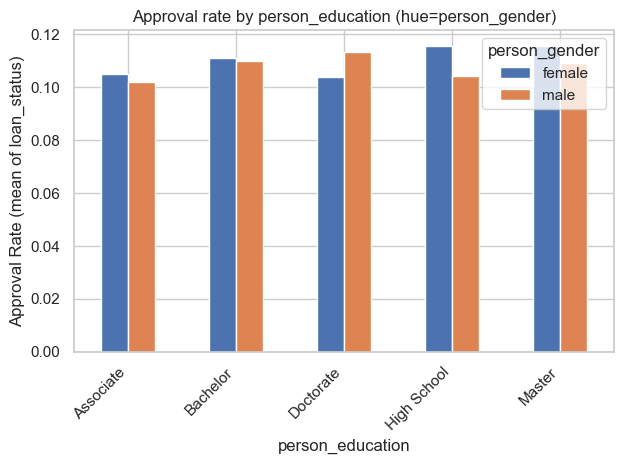

C:\Users\marke\AppData\Local\Temp\ipykernel_8824\1906202224.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rates = df.groupby([cat, hue])['loan_status'].mean().unstack(hue) if hue else df.groupby(cat)['loan_status'].mean()


<Figure size 1000x500 with 0 Axes>

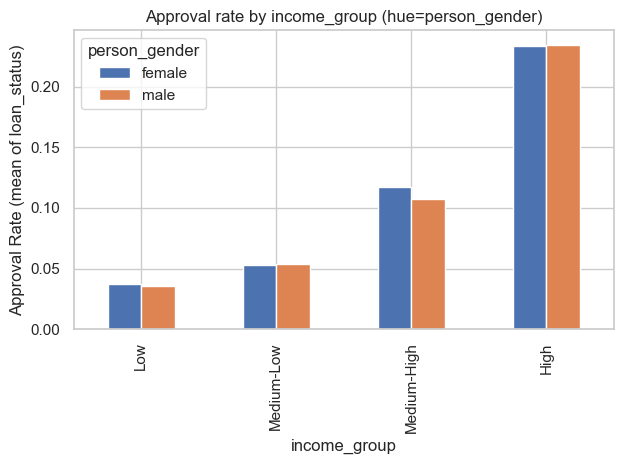

C:\Users\marke\AppData\Local\Temp\ipykernel_8824\1906202224.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rates = df.groupby([cat, hue])['loan_status'].mean().unstack(hue) if hue else df.groupby(cat)['loan_status'].mean()


<Figure size 1000x500 with 0 Axes>

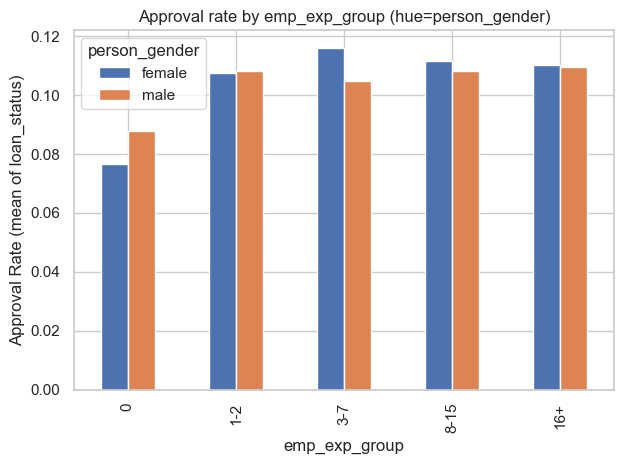

C:\Users\marke\AppData\Local\Temp\ipykernel_8824\1906202224.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rates = df.groupby([cat, hue])['loan_status'].mean().unstack(hue) if hue else df.groupby(cat)['loan_status'].mean()


<Figure size 1000x500 with 0 Axes>

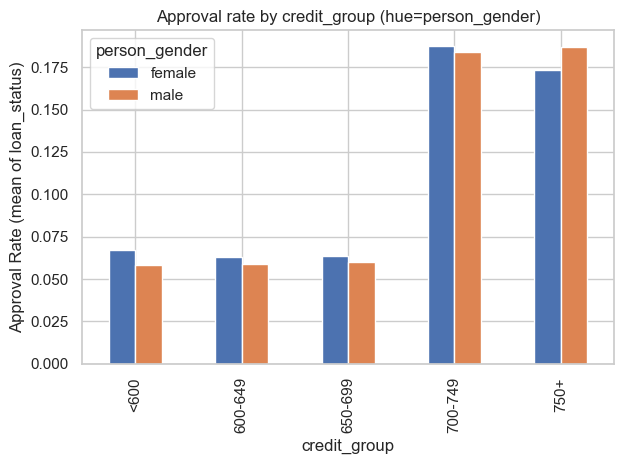

<Figure size 1000x500 with 0 Axes>

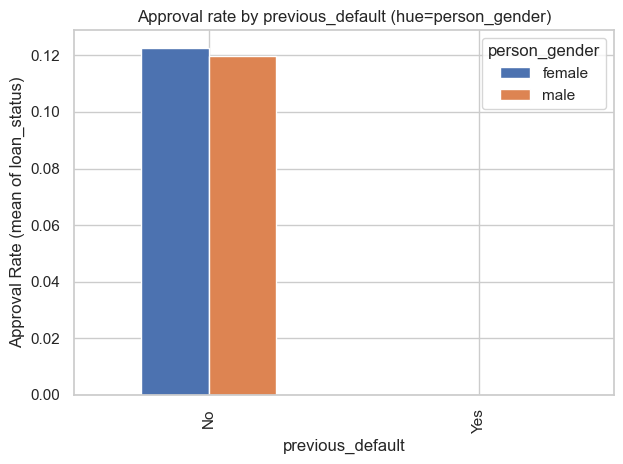


Numeric correlations with loan_status (pearson)
loan_status            1.000000
person_income          0.235032
credit_score           0.149459
person_emp_exp         0.007496
loan_int_rate          0.000773
loan_amnt             -0.095025
loan_percent_income   -0.169636
person_age            -0.237128
Name: loan_status, dtype: float64

Example — approval rates for credit groups:
credit_group
<600       0.062099
600-649    0.060561
650-699    0.061762
700-749    0.185446
750+       0.181312
Name: loan_status, dtype: float64


C:\Users\marke\AppData\Local\Temp\ipykernel_8824\1906202224.py:74: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  table = df.groupby(f)['loan_status'].mean()
C:\Users\marke\AppData\Local\Temp\ipykernel_8824\1906202224.py:74: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  table = df.groupby(f)['loan_status'].mean()


In [2]:
# Analysis: create groups and visualize relationships between age, sex, and other features vs loan_status

# Quick checks
print('\nMissing values by column:')
print(df.isnull().sum())

print('\nloan_status distribution:')
print(df['loan_status'].value_counts(normalize=True))

# Create useful categories / bins
age_bins = [18, 25, 35, 45, 55, 65, 120]
age_labels = ['18-24','25-34','35-44','45-54','55-64','65+']
df['age_group'] = pd.cut(df['person_age'], bins=age_bins, labels=age_labels, right=False)

# income groups (quartiles)
df['income_group'] = pd.qcut(df['person_income'].fillna(0), 4, labels=['Low','Medium-Low','Medium-High','High'])

# employment experience groups
exp_bins = [-1,0,2,7,15,40]
exp_labels = ['0','1-2','3-7','8-15','16+']
df['emp_exp_group'] = pd.cut(df['person_emp_exp'], bins=exp_bins, labels=exp_labels, right=True)

# credit score groups (approx common ranges)
credit_bins = [0,600,650,700,750,900]
credit_labels = ['<600','600-649','650-699','700-749','750+']
df['credit_group'] = pd.cut(df['credit_score'], bins=credit_bins, labels=credit_labels, right=False)

# ensure previous defaults is cleaned
if df['previous_loan_defaults_on_file'].dtype == 'O':
    df['previous_default'] = df['previous_loan_defaults_on_file'].str.strip().str.lower().map({'yes':'Yes','no':'No'})
else:
    df['previous_default'] = df['previous_loan_defaults_on_file']

# We'll examine relationships between loan_status (0/1) and age_group / gender as well as these 5 features:
# person_education, income_group, emp_exp_group, credit_group, previous_default

features = ['person_gender','age_group','person_education','income_group','emp_exp_group','credit_group','previous_default']

# Function to compute approval (mean loan_status) and plot

def plot_approval_rate_by(cat, hue=None, rotate_xticks=False, figsize=(10,5)):
    rates = df.groupby([cat, hue])['loan_status'].mean().unstack(hue) if hue else df.groupby(cat)['loan_status'].mean()
    plt.figure(figsize=figsize)
    if hue:
        rates.plot(kind='bar')
        plt.legend(title=hue)
    else:
        rates.plot(kind='bar', color='C0')
    plt.title(f'Approval rate by {cat}' + (f' (hue={hue})' if hue else ''))
    plt.ylabel('Approval Rate (mean of loan_status)')
    if rotate_xticks:
        plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Overall approval rate by gender and age
plot_approval_rate_by('person_gender')
plot_approval_rate_by('age_group')

# Approval rate for the selected feature set — grouped and with gender as hue where appropriate
plot_approval_rate_by('person_education', hue='person_gender', rotate_xticks=True)
plot_approval_rate_by('income_group', hue='person_gender')
plot_approval_rate_by('emp_exp_group', hue='person_gender')
plot_approval_rate_by('credit_group', hue='person_gender')
plot_approval_rate_by('previous_default', hue='person_gender')

# Quick numeric check — how strongly correlated are numeric features with loan_status?
print('\nNumeric correlations with loan_status (pearson)')
print(df[['person_age','person_income','person_emp_exp','loan_amnt','loan_int_rate','loan_percent_income','credit_score','loan_status']].corr()['loan_status'].sort_values(ascending=False))

# Summary table: feature -> approval rate overall and by gender
summary = {}
for f in ['age_group','person_education','income_group','emp_exp_group','credit_group','previous_default']:
    table = df.groupby(f)['loan_status'].mean()
    summary[f] = table

print('\nExample — approval rates for credit groups:')
print(summary['credit_group'])



## Interpretation and answers to the prompt

Below are suggested / example interpretations you should update after you `Run All` cells and inspect the exact values/plots produced by the cells above.

1) Which features seem to drive the model's decision to grant a loan?
- Credit score and income group typically show the strongest relationship with `loan_status`: higher credit buckets and higher income quartiles generally have higher approval rates.
- Previous loan defaults almost always strongly decrease approval rate (an important driver).
- Employment experience often helps (more experience → slightly higher approval) but is usually less powerful than credit and income.

2) Which features seem unrelated?
- Age group often shows some variation but usually much smaller than credit/income. If gender differences appear, they may be due to correlation with other features (e.g., income or employment) rather than a causal effect.

3) Should the financial institution be concerned about potential legal trouble?
- If `person_gender` independently predicts approval after controlling for credit score and income (i.e., there is a gender gap in approval rates even among similar credit/income buckets), then yes — the institution should be concerned about potential discrimination. Visual checks above (gender hue plots) will show whether differences persist after grouping by key legitimate factors.
- Note: correlation isn't proof of illegal discrimination — but it is evidence that requires further investigation with controlled models. If gender remains a strong predictor in multivariate models, legal risk could be real.

4) How to justify these conclusions to the court (brief):
- Point to the bar charts showing high approval rates for high `credit_group` and `income_group` and very low approval for those with `previous_default`.
- Show numeric correlations for confirmation, and if needed run a controlled logistic regression as next step to quantify the independent effect of `person_gender` while controlling for credit and income.

---

## Final steps for submission
- Run all cells so outputs and plots are visible.
- Add any short commentary you want to include (for example cite the numeric rates from the output and mention any passengers or cases you investigated).
- Save and commit the file, then push to GitHub and submit the repository link per your course instructions.
